# Generalized World Coordinate System  (GWCS)


### Why not FITS WCS?

- Not flexible
  - No distortion handling 
    - distortion paper never approved
    - only one correction per axis allowed
- There's no way to represent discontiguous WCSs.
- It has all the disadvantages of the FITS format, discussed in detail in 

  Thomas, B., Jenness. T. et al. 2015, “The Future of Astronomical Data Formats I. Learning from FITS”. Astronomy & Computing,   
  Volume 12, p. 133-145, arXiv e-print: 1502.00996. https://github.com/timj/aandc-fits

### GWCS Goals

- #### Flexible
  - Combine transforms arbitrarily in an efficient way so that resampling is done as little as possible.
  - Execute subtransforms and their inverse.
  - Insert transforms in the WCS pipeline or change existing transforms.
  - Provide modular tools for managing WCS.
- #### Extensible
  - It should be easy to write new transforms
  

### GWCS Data Model

- A WCS pipeline is a list of steps executed in order
  - Each step defines a starting coordinate frame and the transform to the next frame in the pipeline.
  - The last step has no transform, only a frame which is the output frame of the total transform. 
  - As a minimum a WCS object has an *input_frame* (defaults to "detector"), an *output_frame* and the transform between them.

- The WCS has a domain attribute which defines the range of acceptable inputs.

  The domain is a list of dictionaries - one for each axis 

  {"lower": 5, "upper": 2048, "includes_lower": True, "includes_upper": False}
  
  
- The WCS object is written to file using the Advanced Scientific Data Format (ASDF).

### ASDF

- It has a hierarchical metadata structure, made up of basic dynamic data types such as strings, numbers, lists and mappings.
- It has human-readable metadata that can be edited directly in place in the file.
- ASDF files have the version of the specification they were written to. This makes it possible to evolve the standard while retaining backwards compatibility.
- It’s built on top of industry standards, such as YAML and JSON Schema
- The structure of the data can be automatically validated using schema.

### ASDF and GWCS

- The asdf package contains the schemas which define and validate GWCS.

http://asdf-standard.readthedocs.io/en/latest/

- The asdf package contains also the code which serializes GWCS to disk.

http://asdf.readthedocs.io/en/latest/

#### Example of serializing an astropy.modeling model to a file.

In [ ]:
from asdf import AsdfFile
import numpy as np
from astropy.modeling import models

In [ ]:
# Create a 2D rotation model
rotation = models.Rotation2D(angle=60)
print(rotation)

In [ ]:
# Open an ASDF file object
f = AsdfFile()

# Every ASDF file object has an attribute, called "tree"
# It is a dict like object which store theinformation in YAML format
print(f.tree)

In [ ]:
f.tree['model'] = rotation
f.write_to('rotation.asdf')
#!less rotation.asdf

### GWCS and Astropy

- Transforms in GWCS are instances of models in [astropy.modeling](http://docs.astropy.org/en/stable/modeling/index.html)
- The celestial reference frames in gwcs.coordinate_frames are implemented in [astropy.coordinates](http://docs.astropy.org/en/stable/coordinates/index.html)
- Units and unit conversion is implemented in [astropy.units](http://docs.astropy.org/en/stable/units/index.html)

### JWST and GWCS

GWCS is the software used for managing the WCS of JWST observations.

- The WCS is included in the JWST science files. It is saved in the FITS file as a separate extension with *EXTNAME=ASDF*.
- The WCS includes all transforms from detector to a standard world coordinate system.
- The WCS pipelines for different instrument modes include different intermediate coordinate frames.
- WCS reference files are in ASDF format.

### Imaging - A Programmatic Example

In [1]:
import numpy as np
from astropy.modeling import models
from astropy import units as u
from astropy import coordinates as coord
from asdf import AsdfFile
from gwcs import wcs
from gwcs import coordinate_frames as cf
from gwcs import wcstools
from gwcs import utils as gwutils

In [2]:
# Create two polynomial models 
polyx = models.Polynomial2D(4)
polyx.parameters = np.random.randn(15)
polyy = models.Polynomial2D(4)
polyy.parameters = np.random.randn(15)
distortion = (models.Mapping((0, 1, 0, 1)) | polyx & polyy).rename("distortion")
f = AsdfFile()
f.tree['model'] = distortion
f.write_to('poly.asdf', all_array_storage='inline')
#!less poly.asdf

In [3]:
undist2sky = (models.Shift(-10.5) & models.Shift(-13.2) | models.Rotation2D(0.0023) | \
              models.Scale(.01) & models.Scale(.04) | models.Pix2Sky_TAN() | \
              models.RotateNative2Celestial(5.6, -72.05, 180)).rename("undistorted2sky")

In [4]:
detector_frame = cf.Frame2D(name="detector", axes_names=("x", "y"), unit=(u.pix, u.pix))
sky_frame = cf.CelestialFrame(name="icrs", reference_frame=coord.ICRS())
focal_frame = cf.Frame2D(name="focal_frame", unit=(u.arcsec, u.arcsec))

In [9]:
pipeline = [(detector_frame, distortion),
            (focal_frame, undist2sky),
            (sky_frame, None)
            ]
wcsobj = wcs.WCS(pipeline)
print(wcsobj)

    From       Transform   
----------- ---------------
   detector      distortion
focal_frame undistorted2sky
       icrs            None


In [10]:
# Calling the WCS object like a function evaluates the transforms.
ra, dec = wcsobj(500, 600)
print(ra, dec)

16.008726390741394 17.67313523642333


In [11]:
# Display the frames available in the WCS pipeline
print(wcsobj.available_frames)

['detector', 'focal_frame', 'icrs']


In [12]:
wcsobj.input_frame

<Frame2D(name="detector", unit=(Unit("pix"), Unit("pix")), axes_names=('x', 'y'), axes_order=(0, 1))>

In [15]:
wcsobj.output_frame

<CelestialFrame(name="icrs", unit=(Unit("deg"), Unit("deg")), axes_names=('lon', 'lat'), axes_order=(0, 1), reference_frame=<ICRS Frame>)>

In [16]:
# Because the output_frame is a CoordinateFrame object we can get as output
# coordinates.SkyCoord objects.
skycoord = wcsobj(1, 2, output="numericals_plus")
print(skycoord)

<SkyCoord (ICRS): (ra, dec) in deg
    ( 5.33981049, -71.81620703)>


In [17]:
print(skycoord.transform_to('galactic'))

<SkyCoord (Galactic): (l, b) in deg
    ( 306.24972505, -45.11777688)>


In [18]:
print(wcsobj.output_frame.coordinates(ra, dec))

<SkyCoord (ICRS): (ra, dec) in deg
    ( 16.00872639,  17.67313524)>


### Methods for managing the transforms

In [19]:
# It is possible to retrieve the transform between any
# two coordinate frames in the WCS pipeline
print(wcsobj.available_frames)

['detector', 'focal_frame', 'icrs']


In [20]:
det2focal = wcsobj.get_transform("detector", "focal_frame")
fx, fy = det2focal(1, 2)
print(fx, fy)

2.3805516740935873 19.040803617391592


In [22]:
# And we can see what the units are in focal_frame
print(wcsobj.focal_frame.coordinates(fx, fy))

(<Quantity 2.3805516740935873 arcsec>, <Quantity 19.040803617391592 arcsec>)


In [23]:
# It is also possible to replace a transform 
# Create a transforms which shifts in X and y
new_det2focal = models.Shift(3) & models.Shift(12)
# Replace the transform between "detector" and "v2v3"
wcsobj.set_transform("detector", "focal_frame", new_det2focal)
new_ra, new_dec = wcsobj(500, 600)
print(ra, dec)
print(new_ra, new_dec)

16.008726390741394 17.67313523642333
12.542455839834997 -49.15389307219613


In [24]:
# We can insert a transform in the pipeline just before or after a frame
rotation = models.EulerAngleRotation(.1, 12, 180, axes_order="xyz")
wcsobj.insert_transform("focal_frame", rotation)
wcsobj.get_transform("detector", "focal_frame")(1, 2)

(-175.6556532023201, 25.96129074500988)

### Discontiguous transforms

There are cases when different WCS transforms apply to different regions of the same image.

JWST observations with the IFUs, the NIRSpec MOS and fixed slits, the NIRISS SOSS and the WFSS,
are all examlpes of discontiguos WCSs.

GWCS manages this by packaging the transforms in a single WCS object.

Individual WCSs are accessed using additional inputs. These non-coordinate inputs depend on the specific mode. 

For the NIRSpec fixed slits the input is the slit name, for the IFU - the slice number, for the MOS - the sltlet_id, for NIRISS SOSS - the spectral order.


### NIRSpec Fixed Slit Example

In [26]:
from jwst import datamodels
nrs_fs = "nrs1_assign_wcs.fits.gz"
nrs = datamodels.ImageModel(nrs_fs)
from jwst.assign_wcs import nirspec
slits = nirspec.get_open_slits(nrs)
print(slits[0])

Slit(name='S200A1', shutter_id=0, xcen=0, ycen=0, ymin=-0.5, ymax=0.5, quadrant=5, source_id=0, nshutters=0, source_name='', source_alias='', catalog_id='', stellarity=0.0, source_xpos=0.0, source_ypos=0.0)


In [43]:
slits = nirspec.get_open_slits(nrs)
for s in slits:
    print(s)

Slit(name='S200A1', shutter_id=0, xcen=0, ycen=0, ymin=-0.5, ymax=0.5, quadrant=5, source_id=0, nshutters=0, source_name='', source_alias='', catalog_id='', stellarity=0.0, source_xpos=0.0, source_ypos=0.0)
Slit(name='S200A2', shutter_id=1, xcen=0, ycen=0, ymin=-0.5, ymax=0.5, quadrant=5, source_id=0, nshutters=0, source_name='', source_alias='', catalog_id='', stellarity=0.0, source_xpos=0.0, source_ypos=0.0)
Slit(name='S400A1', shutter_id=2, xcen=0, ycen=0, ymin=-0.5, ymax=0.5, quadrant=5, source_id=0, nshutters=0, source_name='', source_alias='', catalog_id='', stellarity=0.0, source_xpos=0.0, source_ypos=0.0)
Slit(name='S1600A1', shutter_id=3, xcen=0, ycen=0, ymin=-0.5, ymax=0.5, quadrant=5, source_id=0, nshutters=0, source_name='', source_alias='', catalog_id='', stellarity=0.0, source_xpos=0.0, source_ypos=0.0)
Slit(name='S200B1', shutter_id=4, xcen=0, ycen=0, ymin=-0.5, ymax=0.5, quadrant=5, source_id=0, nshutters=0, source_name='', source_alias='', catalog_id='', stellarity=0.0

In [44]:
s0 = nirspec.nrs_wcs_set_input(nrs, "S200A1")
print(s0.domain)

[{'upper': 1641, 'lower': 0}, {'upper': 231, 'lower': 169}]


In [45]:
s0.available_frames

['detector', 'sca', 'gwa', 'slit_frame', 'msa_frame', 'oteip', 'v2v3', 'world']

In [46]:
s0.output_frame

[<CelestialFrame(name="sky", unit=(Unit("deg"), Unit("deg")), axes_names=('lon', 'lat'), axes_order=(0, 1), reference_frame=<ICRS Frame>)>, <SpectralFrame(name="spectral", unit=(Unit("um"),), axes_names=('wavelength',), axes_order=(2,))>]

In [32]:
ra, dec, lam = s0(x, y)

In [48]:
res = s0(1000, 200, output="numericals_plus")
print(res)

sky [5.670327762841917, -72.31292917354918] (0, 1)
spectral [1.0484778510369612] (2,)
[<SkyCoord (ICRS): (ra, dec) in deg
    ( 5.67032776, -72.31292917)>, <Quantity 1.0484778510369612 um>]


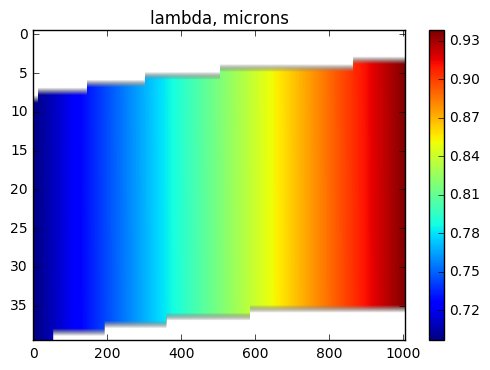

In [49]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(lam, aspect='auto')
plt.title("lambda, microns")
plt.colorbar()